In [1]:
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.visualization import plot_histogram
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt 

In [8]:
from qiskit import *
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')

ibmqfactory.load_account:WARNING:2020-09-12 22:00:45,268: Credentials are already in use. The existing account in the session will be replaced.


In [37]:
pip install pennylane-qiskit


  Using cached PennyLane_qiskit-0.11.0-py3-none-any.whl (21 kB)
  Using cached qiskit-0.20.1.tar.gz (3.9 kB)
  Using cached pyscf-1.7.2.tar.gz (7.5 MB)
Note: you may need to restart the kernel to use updated packages.


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\nikhi\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\nikhi\\AppData\\Local\\Temp\\pip-install-42qof97u\\pyscf\\setup.py'"'"'; __file__='"'"'C:\\Users\\nikhi\\AppData\\Local\\Temp\\pip-install-42qof97u\\pyscf\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\nikhi\AppData\Local\Temp\pip-install-42qof97u\pyscf\pip-egg-info'
         cwd: C:\Users\nikhi\AppData\Local\Temp\pip-install-42qof97u\pyscf\
    Complete output (9 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\nikhi\AppData\Local\Temp\pip-install-42qof97u\pyscf\setup.py", line 207, in <module>
        for x in blas_libraries]
      File "C:\Users\nikhi\AppData\Local\Temp\pip-install-42qof97u\pyscf\s

In [32]:
from qiskit.providers.aer.noise import NoiseModel
#noise_model = NoiseModel.from_backend(backend)

#dev = qml.device("qiskit.aer", wires=2, shots=1000, noise_model = noise_model, analytic=False)
dev1 = qml.device("cirq.mixedsimulator", wires=2)
#dev = qml.device('qiskit.aer', wires=2)

from pennylane_cirq import ops as cirq_ops

@qml.qnode(dev1)
def circuit(params, noise_param = 0.2):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires = [0,1])
    cirq_ops.Depolarize(noise_param, wires=0)
    return qml.probs(wires = [0,1])

In [33]:
def cost_fun(params):
    prob = circuit(params)
    p00, p01, p10, p11 = prob
    cost = (p00)**2 + (0.5 - p01)**2 + (0.5 - p10)**2 + (p11)**2
    return cost

In [34]:
initial_parameters = np.random.randn(2) #starting with random parameters
dev1.shots = 1
n_steps = 50

#backend = provider.get_backend('qasm_simulator')



params = initial_parameters.copy()
optimizer = qml.GradientDescentOptimizer(stepsize=0.6) #The Gradient Descent Optimizer
costs = []

for i in range(n_steps):
    costs.append(cost_fun(params))
    params = optimizer.step(cost_fun, params)
        
    costs.append(costs)

print(params)
print(cost_fun(params))

[-1.57079628  3.0960014 ]
0.017879534851864776


In [35]:
pcosts = []
for i in range(len(costs)):
    if i%2 == 0:
        pcosts.append(costs[i])

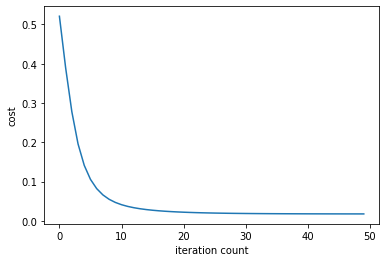

In [36]:

plt.plot(range(n_steps),pcosts)
plt.xlabel('iteration count') 
plt.ylabel('cost') 
plt.show()

In [ ]:
cost, prob = cost_fun([pi/2,pi/2])

In [ ]:
result = {'00': prob[0], '01': prob[1], '10': prob[2], '11': prob[3]}
plot_histogram(result)
